In [25]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pyranges as pr
import itertools
from collections import defaultdict
import os
import glob
import sys
sys.path.append("/Genomics/kocherlab/bjarnold/STARRseq/code/notebooks")
import functions as fn



In [26]:
fold_diff_0 = "_MACS2_peaks_qval_0_folddiff_0.txt"
fold_diff_2 = "_MACS2_peaks_qval_0_folddiff_2.txt"


In [27]:
def combine_dfs_across_fold_diffs(MACS_files_0, MACS_files_2, min_biorep_support):
    dfs = []
    for f0,f2 in zip(MACS_files_0, MACS_files_2):
        if 'prop' not in f0 and 'prop' not in f2: 
            df0 = pd.read_table(f0, sep=" ")
            df2 = pd.read_table(f2, sep=" ")
            df0["fold_diff"] = 0
            df2["fold_diff"] = 2
            df0['species'] = os.path.basename(f0).split("_")[0]
            df2['species'] = os.path.basename(f2).split("_")[0]
            df = pd.concat([df0, df2])
            df['min_biorep_support'] = min_biorep_support
            df = df[['species', 'raw', 'dedup', 'fold_diff', 'min_biorep_support']]
            dfs.append(df)
    return dfs

def combine_dfs_across_fold_diffs_Amel_downsampling(MACS_files_0, MACS_files_2, min_biorep_support):
    dfs = []
    for f0,f2 in zip(MACS_files_0, MACS_files_2):
        if 'prop' in f0 and 'prop' in f2: 
            df0 = pd.read_table(f0, sep=" ")
            df2 = pd.read_table(f2, sep=" ")
            df0["fold_diff"] = 0
            df2["fold_diff"] = 2
            df0['species'] = "_".join(os.path.basename(f0).split("_")[0:2])
            df2['species'] = "_".join(os.path.basename(f2).split("_")[0:2])
            df = pd.concat([df0, df2])
            df['min_biorep_support'] = min_biorep_support
            df = df[['species', 'raw', 'dedup', 'fold_diff', 'min_biorep_support']]
            dfs.append(df)
    return dfs


In [28]:
data_dir = "MACS2_summaries/min_biorep_support_3"
MACS_files_fd_0 = sorted(glob.glob(os.path.join(data_dir, "*"+fold_diff_0)))
MACS_files_fd_2 = sorted(glob.glob(os.path.join(data_dir, "*"+fold_diff_2)))
dfs_min_biorep_supp_3 = combine_dfs_across_fold_diffs(MACS_files_fd_0, MACS_files_fd_2, 3)
dfs_min_biorep_supp_3_Ameldownsamp = combine_dfs_across_fold_diffs_Amel_downsampling(MACS_files_fd_0, MACS_files_fd_2, 3)


data_dir = "MACS2_summaries/min_biorep_support_2"
MACS_files_fd_0 = sorted(glob.glob(os.path.join(data_dir, "*"+fold_diff_0)))
MACS_files_fd_2 = sorted(glob.glob(os.path.join(data_dir, "*"+fold_diff_2)))
dfs_min_biorep_supp_2 = combine_dfs_across_fold_diffs(MACS_files_fd_0, MACS_files_fd_2, 2)
dfs_min_biorep_supp_2_Ameldownsamp = combine_dfs_across_fold_diffs_Amel_downsampling(MACS_files_fd_0, MACS_files_fd_2, 2)

assert len(dfs_min_biorep_supp_3) == len(dfs_min_biorep_supp_2)

In [29]:
dfs_min_biorep_supp_3_Ameldownsamp[1]

,species,raw,dedup,fold_diff,min_biorep_support
0,Amel_prop0.01,21453,23475,0,3
0,Amel_prop0.01,12066,11980,2,3


In [30]:
def concat_dfs(dfs_min_biorep_supp_3, dfs_min_biorep_supp_2):
    dfs = []
    for df3, df2 in zip(dfs_min_biorep_supp_3, dfs_min_biorep_supp_2):
        df = pd.concat([df3, df2])
        assert len(df) == len(df3) + len(df2)
        assert len(df['species'].unique()) == 1
        dfs.append(df)

    df = pd.concat(dfs)
    return df

df = concat_dfs(dfs_min_biorep_supp_3, dfs_min_biorep_supp_2)
df.head()

# dfs = []
# for df3, df2 in zip(dfs_min_biorep_supp_3, dfs_min_biorep_supp_2):
#     df = pd.concat([df3, df2])
#     assert len(df) == len(df3) + len(df2)
#     assert len(df['species'].unique()) == 1
#     dfs.append(df)

# df = pd.concat(dfs)
# df.head()

,species,raw,dedup,fold_diff,min_biorep_support
0,Aaur,15373,2515,0,3
0,Aaur,5026,413,2,3
0,Aaur,29100,3555,0,2
0,Aaur,8238,755,2,2
0,Amel,34032,17036,0,3


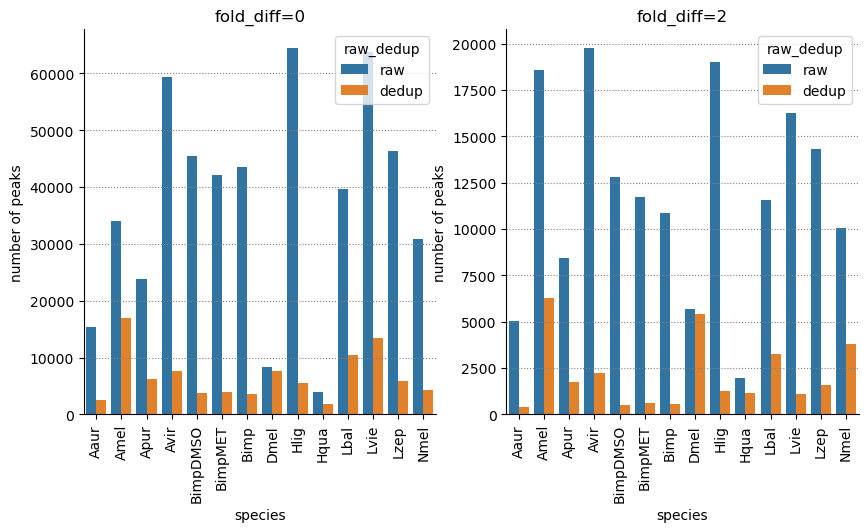

In [31]:
# How does deduplication affect the number of peaks?

# combine raw and dedup columns into single column with categorical variable
df_melt = pd.melt(df,  
                  value_vars=['raw', 'dedup'],
                  var_name='raw_dedup', 
                  value_name='num_peaks',
                  id_vars=['species', 'fold_diff', 'min_biorep_support'])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

def make_barplot_func1(df_melt, min_biorep_support, fold_diff, ax):
    sns.barplot(x='species', 
                y='num_peaks', 
                hue='raw_dedup', 
                data=df_melt[(df_melt.min_biorep_support == min_biorep_support) & (df_melt.fold_diff == fold_diff)],
                ax=ax)
    ax.set_title(f"fold_diff={fold_diff}")
    ax.set_ylabel("number of peaks")
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.grid(color='gray', linestyle='dotted', axis='y', zorder=0)
    return ax

make_barplot_func1(df_melt, 3, 0, axs[0])
make_barplot_func1(df_melt, 3, 2, axs[1])
sns.despine()



In [32]:
df.head()

,species,raw,dedup,fold_diff,min_biorep_support
0,Aaur,15373,2515,0,3
0,Aaur,5026,413,2,3
0,Aaur,29100,3555,0,2
0,Aaur,8238,755,2,2
0,Amel,34032,17036,0,3


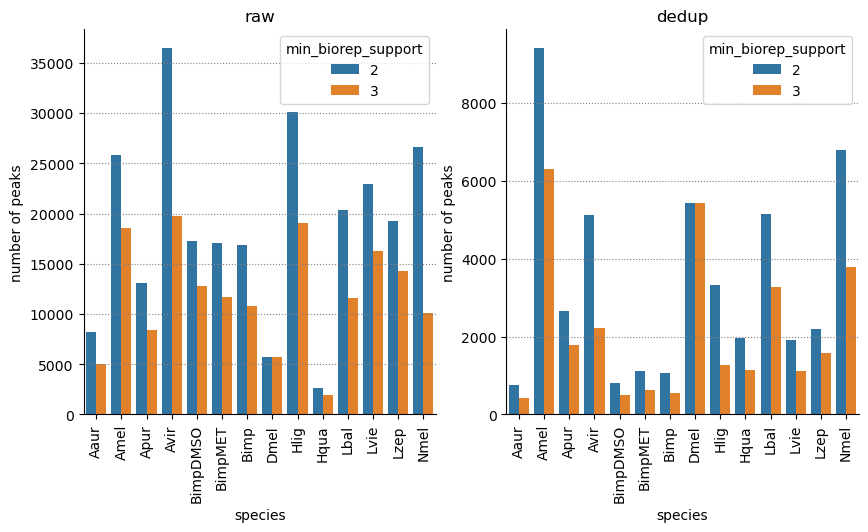

In [33]:
# how does using 2+ biorep support affect the number of peaks?


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

def make_barplot_func2(df, raw_dedup, ax):
    sns.barplot(x='species', 
                y=raw_dedup, 
                hue='min_biorep_support', 
                data=df,
                ax=ax)
    ax.set_title(f"{raw_dedup}")
    ax.set_ylabel("number of peaks")
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.grid(color='gray', linestyle='dotted', axis='y', zorder=0)
    return ax

make_barplot_func2(df[df.fold_diff == 2], "raw", axs[0])
make_barplot_func2(df[df.fold_diff == 2], "dedup", axs[1])
sns.despine()



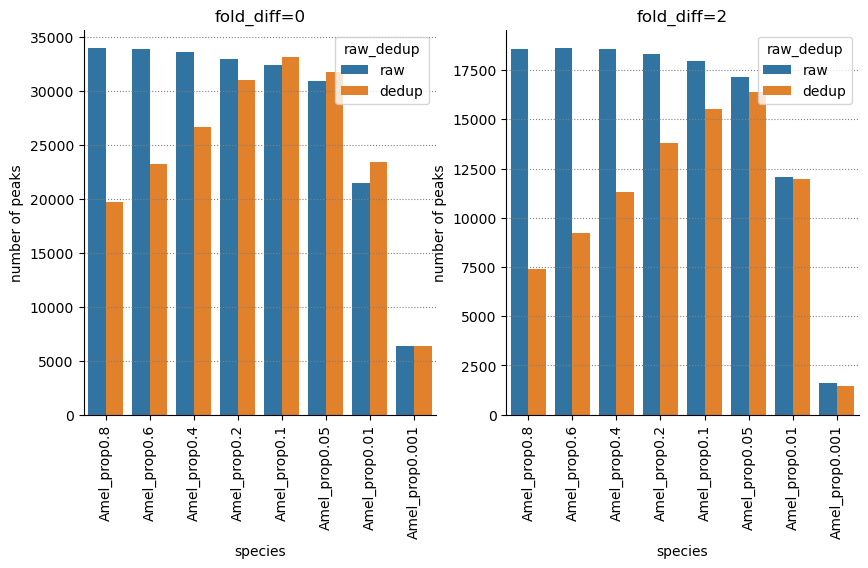

In [44]:
df = concat_dfs(dfs_min_biorep_supp_3_Ameldownsamp, dfs_min_biorep_supp_2_Ameldownsamp)


# combine raw and dedup columns into single column with categorical variable
df_melt = pd.melt(df,  
                  value_vars=['raw', 'dedup'],
                  var_name='raw_dedup', 
                  value_name='num_peaks',
                  id_vars=['species', 'fold_diff', 'min_biorep_support'])
df_melt.sort_values(by=['species', 'raw_dedup'], ascending=False, inplace=True)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

make_barplot_func1(df_melt, 3, 0, axs[0])
make_barplot_func1(df_melt, 3, 2, axs[1])
# specify order of species on x axis
# order = ['Amel_prop0.8', 'Amel_prop0.6', 'Amel_prop0.4', 'Amel_prop0.2', 'Amel_prop0.1', 'Amel_prop0.05', 'Amel_prop0.01', 'Amel_prop0.001']
# axs[0].set_xticklabels(order)
# axs[1].set_xticklabels(order)

sns.despine()

In [42]:
# sort df_melt by species


,species,fold_diff,min_biorep_support,raw_dedup,num_peaks
63,Amel_prop0.8,2,2,dedup,10864
29,Amel_prop0.8,2,3,raw,18570
60,Amel_prop0.8,0,3,dedup,19726
31,Amel_prop0.8,2,2,raw,25886
30,Amel_prop0.8,0,2,raw,47297
...,...,...,...,...,...
33,Amel_prop0.001,2,3,dedup,1472
1,Amel_prop0.001,2,3,raw,1629
3,Amel_prop0.001,2,2,raw,6845
2,Amel_prop0.001,0,2,raw,28704


In [35]:
df[df.fold_diff == 2]

,species,raw,dedup,fold_diff,min_biorep_support
0,Amel_prop0.001,1629,1472,2,3
0,Amel_prop0.001,6845,6119,2,2
0,Amel_prop0.01,12066,11980,2,3
0,Amel_prop0.01,24023,23012,2,2
0,Amel_prop0.05,17163,16376,2,3
0,Amel_prop0.05,26356,23661,2,2
0,Amel_prop0.1,17942,15537,2,3
0,Amel_prop0.1,26274,21167,2,2
0,Amel_prop0.2,18319,13780,2,3
0,Amel_prop0.2,26103,18724,2,2


In [36]:
df[df.fold_diff == 2]

,species,raw,dedup,fold_diff,min_biorep_support
0,Amel_prop0.001,1629,1472,2,3
0,Amel_prop0.001,6845,6119,2,2
0,Amel_prop0.01,12066,11980,2,3
0,Amel_prop0.01,24023,23012,2,2
0,Amel_prop0.05,17163,16376,2,3
0,Amel_prop0.05,26356,23661,2,2
0,Amel_prop0.1,17942,15537,2,3
0,Amel_prop0.1,26274,21167,2,2
0,Amel_prop0.2,18319,13780,2,3
0,Amel_prop0.2,26103,18724,2,2
